# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [1]:
from google.colab import drive # блок для google colab
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('gdrive/MyDrive/titanic_train.csv') # датасет

Установите количество пропущенных значений поля <code>age</code>:

In [4]:
df['age'].isna().sum()

199

Определите долю выживших

In [5]:
df['survived'].value_counts()[1]/\
len(df) # 1 - выжившие , 0 - погибшие на ивт 

0.382262996941896

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [6]:
name = (df.isnull().sum() * 100 / len(df)) >33.3333
for key, value in name.iteritems():
  if (value):
    df.drop(key,axis=1,inplace=True)
df.drop('ticket',axis=1,inplace=True)
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [8]:
df['fam_size'] = df['sibsp'] + df['parch']
df.drop(['sibsp','parch'],axis=1,inplace=True)
df['fam_size'].mean() #Вычислите выборочное среднее колонки fam_size.

0.8664627930682977

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [9]:
len(df.columns)-1

7

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [10]:
len(df[(df['sex'] == 'female') & (df['pclass'] == 1) & (df['survived'] == 1)]) /\
len(df[(df['sex'] == 'female') & (df['pclass'] == 1)])

0.9711538461538461

Постройте гистограммы выжиших и невыживших по возрастам.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

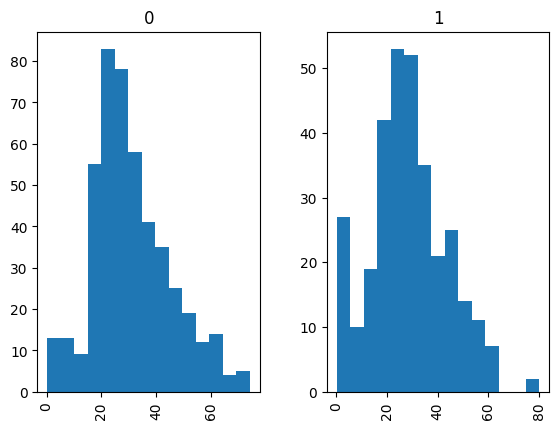

In [11]:
df.hist('age','survived',bins=15) # 1 - выжившие , 0 - погибшие на ивт 

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [15]:
df1 = df.dropna()
x = df1.drop(['name', 'sex', 'embarked','survived'], axis=1)
y = df1['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1,stratify=y)
model = LogisticRegression(random_state=11, max_iter=1000).fit(x_train,y_train)
f1_score(y_test,model.predict(x_test))

0.5098039215686275

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
df1 = df
for i in df.select_dtypes(include=np.number).columns:
  df1[i].fillna((df1[i].mean()), inplace=True)
x = df1.drop(['survived','pclass','name','sex','embarked'],axis=1)
y = df1['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
model = LogisticRegression(random_state=11, max_iter=1000).fit(x_train,y_train)
f1_score(y_test,model.predict(x_test))

0.4672897196261682

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [ ]:
import re 
names_prefix ={}
for i in df['name']:
  word = re.search('\,(.*?)\.', i).group()
  names_prefix[word] = 1
len(names_prefix)


14

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [ ]:
df['honorific'] = df.apply(lambda row:\
                           re.search('\,(.*?)\.', row['name']).group()[2:-1], axis = 1)
def change_value(s):
  if s in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']:
    return 'Mr'
  if s in ['Dona', 'Countess']:
    return 'Mrs'
  if s in ['Mlle', 'Ms']:
    return 'Miss'
  return s

df['honorific'] = df.apply(lambda row: change_value(row['honorific']), axis = 1)

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [ ]:
 (df[df['sex'] == 'male'])['honorific'].value_counts()

Mr        590
Master     46
Name: honorific, dtype: int64

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [ ]:
(df[df['honorific'] == 'Miss'])['age'].mean()

22.00576540880503

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
val_ = df['honorific'].value_counts().index.tolist()
for i in val_:
  cond = (df['honorific'] == i)
  df.loc[cond,'age'] = df.loc[cond,'age'].fillna(df.loc[cond,'age'].median())



0

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
# < ENTER YOUR CODE HERE > 